# Part 2 : Training and labelizing

## Import Libraries & Dependencies & Functions

In [305]:
# Import Libraries
import os
import numpy as np
import cv2 
import uuid
import time
import wget #Tensorflow Model Zoo
from matplotlib import pyplot as plt
%matplotlib inline
from random import seed
from random import randint

In [460]:
# Install tools
!pip install tensorflow
!pip install tensorflow-gpu
!pip install protobuf matplotlib==3.2
!pip install scipy
!pip install Pillow
!pip install pyyaml
!pip install pytz

^C
^C
^C





In [146]:
# Insert ROI Align function
def roia_and_flatten(img: tf.Tensor, x1: int, y1:int , x2:int , y2: int) -> tf.Tensor:
    # conversion niveau de gris
    img_gray = tf.image.rgb_to_grayscale(img)
    
    # dimensions image
    h, w, _= img.shape

    # rognage image et redimensionnement
    crop = tf.image.crop_and_resize(image=[img_gray],
                                     boxes=[[y1/w, x1/h, y2/w, x2/h]],
                                     box_indices=[0], crop_size=[32, 16])
    
    # vectorisation du tenseur
    return tf.reshape(*crop, 512)  # dtype=float32 shape=(512) min=0 max=1

In [226]:
# Insert Triplet loss function
def triplet_loss(A: tf.Tensor, P: tf.Tensor, N: tf.Tensor, alpha=0.3) -> float:
    ap = tf.norm(A - P, ord='euclidean', axis=None, keepdims=None, name=None)
    an = tf.norm(A - N, ord='euclidean', axis=None, keepdims=None, name=None)
    
    return abs(ap - an + alpha)

## Configuration & Installation

In [459]:
# define some variable for our model and use them properly for the rest of the script  
ml_model = 'faster_r_3D_cnn' 
ml_model_pretrained = 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8'
ml_model_pretrained_tensorflow = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz' 
label_map = 'label_map.pbtxt'

# define and create some repository in order to organize the project and stock their corresponding content  
paths = {
    'script_path': os.path.join('Tensorflow','scripts'),
    'Tensorflow_model_path': os.path.join('Tensorflow','models'),
    'annotation_path': os.path.join('Tensorflow', 'workspace','annotations'),
    'image_path': os.path.join('Tensorflow', 'workspace','images'),
    'model_path': os.path.join('Tensorflow', 'workspace','models'),
    'pretrained_model_path': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'checkpoint_path': os.path.join('Tensorflow', 'workspace','models',ml_model), 
    'protoc_path':os.path.join('Tensorflow','protoc') }

for path in paths.values():
    !mkdir {path}

files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', ml_model, 'pipeline.config'),
    'TF_SCRIPT': os.path.join(paths['script_path'], 'generate_tfrecord.py'), 
    'LABELMAP': os.path.join(paths['annotation_path'], label_map)
}


In [ ]:
# Clone TF Models Pretrained Models from Tensorflow Model Zoo

!git clone https://github.com/tensorflow/models {paths['Tensorflow_model_path']}

In [ ]:
# Install Tensorflow Object Detection 

url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
wget.download(url)
!move protoc-3.15.6-win64.zip {paths['protoc_path']}
!cd {paths['protoc_path']} && tar -xf protoc-3.15.6-win64.zip
os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['protoc_path'], 'bin'))   
!cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
!cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
# Insert the Tensorflow object detection 
import object_detection

wget.download(ml_model_pretrained_tensorflow)
!move {ml_model_pretrained +'.tar.gz'} {paths['pretrained_model_path']}
!cd {paths['pretrained_model_path']} && tar -zxvf {ml_model_pretrained +'.tar.gz'}

## Label Map

In [ ]:
# Define and create the label map (For Demo we define two label Frotter and Marcher)
labels = [{'name':'Frotter', 'id':1}, {'name':'Marcher', 'id':2}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

## Create Tensorflow records

In [ ]:
# Clone the git below in order to prepare the Tensorflow records of our train and test frames that will be used for updating our model configuration
!git clone https://github.com/nicknochnack/GenerateTFRecord {paths['script_path']}

In [ ]:
# Create the Tensorflow records
!python {files['TF_SCRIPT']} -x {os.path.join(paths['image_path'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['annotation_path'], 'train.record')} 
!python {files['TF_SCRIPT']} -x {os.path.join(paths['image_path'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['annotation_path'], 'test.record')} 

## Prepare the Faster R-CNN model configuration

In [ ]:
# Insert the general Faster R-CNN configuration model from tensorflow to our local model
!copy {os.path.join(paths['pretrained_model_path'], ml_model_pretrained, 'pipeline.config')} {os.path.join(paths['checkpoint_path'])}

In [ ]:
# Insert libraries
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
# Insert the configuration of model
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG']) 
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
# Update the configuration of model
pipeline_config.model.faster_rcnn.num_classes = len(labels)
pipeline_config.train_config.batch_size = 2 # For demo we set two label "Marcher" and "Frotter"
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['pretrained_model_path'], ml_model_pretrained, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['annotation_path'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['annotation_path'], 'test.record')]

In [ ]:
# Save the configuration of model
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)

## Train the Faster R-CNN model

In [6]:
# Prepare the execution script of our Faster R-CNN model for 1000 steps
script = os.path.join(paths['Tensorflow_model_path'], 'research', 'object_detection', 'model_main_tf2.py')
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=1000".format(script, paths['checkpoint_path'],files['PIPELINE_CONFIG'])

In [ ]:
# Execution of the model
!{command}

## Use the trained Faster R-CNN model

### Configuration 

In [122]:
# Insert libraries 
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [167]:
# Insert model configuration 
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

# Build the detection model
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['checkpoint_path'], 'ckpt-6')).expect_partial()

# Define the detection function that use the trained model Faster R-CNN
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

### Detect and labeling the Anchor (Key Frame)

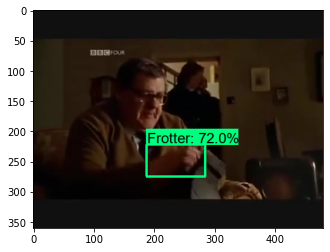

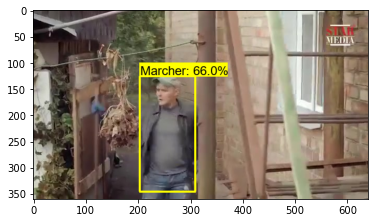

In [287]:
# We pass through two serie of frames and applicate our trained model in order to extract the bounding boxes with their corresponding label :
# Serie 1 has 81 frame wich contain 31 frame of label "Frotter"  
# Serie 2 has 155 frame wich contain 31 frame of label "Marcher"

for serie_num in range(1,3):
    
    serie_name = 'serie ' + str(serie_num)

    category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

    image_path = os.path.join(paths['image_path'], serie_name, '47.jpg') #image 47 = key frame of 31 frame

    img = cv2.imread(image_path)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes'] + label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=1,
                min_score_thresh=.6, # .6 (60%) represent the threshold that we fix to filter the confidence rate of bounding boxs
                agnostic_mode=False)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()

### Extract the Bounding Boxs

In [366]:
# Image Dimensions
X = np.shape(image_original)[1]
Y = np.shape(image_original)[0]

In [367]:
# Extract Bounding Box Dimensions ( x1,y1 --> Bottom Left Point , x2,y2 --> Top Right Point  )

x1_norm = detections['detection_boxes'][0][1]
y1_norm = detections['detection_boxes'][0][2]
x2_norm = detections['detection_boxes'][0][3]
y2_norm = detections['detection_boxes'][0][0]

x1 = int(x1_norm * X)
y1 = int(y1_norm * Y)
x2 = int(x2_norm * X)
y2 = int(y2_norm * Y)

### Extract the Bounding Boxs from Positive and Negative + ROI Align

#### Anchor

In [368]:
# We pass the extracted bounding box from Anchor through the ROI Align function to extract its corresponding vector

A_vect = roia_and_flatten(image_np, x1, y1, x2, y2)

#### Positive

In [369]:
# We pass the previous extracted bounding box from Positive through the ROI Align function to extract its corresponding vector

P_vect_serie = [[],[]]

for serie_num in range(1,3):
    
    serie_name = 'serie ' + str(serie_num)
    
    for image_num in range(32,63):
        
        if image_num != 47 :
            
            P_img_name = str(image_num) + '.jpg'
            P_img_path = os.path.join(paths['image_path'], serie_name, P_img_name)
            P_img = cv2.imread(P_img_path)
            P_image_np = np.array(P_img)
            P_vect = roia_and_flatten(P_image_np, x1, y1, x2, y2)
            P_vect_serie[serie_num-1].append(P_vect)
            

#### Negative

In [453]:
# We pass the previous extracted bounding box from Negative through the ROI Align function to extract its corresponding vector

N_vect_serie = [[],[]]

for serie_num in range(1,3):
    
    serie_name = 'serie ' + str(serie_num)
    
    for image_num in range(32,63):
        
        if image_num != 47 :
            
            # Choose a Negative randomly 
            num = 47
            while ( (num > 31) and (num < 63) ):
                num = randint(1, 81)
            
            N_img_name = str(num) + '.jpg'
            N_img_path = os.path.join(paths['image_path'], serie_name, N_img_name)
            N_img = cv2.imread(N_img_path)
            N_image_np = np.array(N_img)
            N_vect = roia_and_flatten(N_image_np, x1, y1, x2, y2)
            N_vect_serie[serie_num-1].append(N_vect)

### Triplet Loss

In [454]:
# Use the triplet loss function on Anchor, Positive and Negative

res_triplet_loss_serie = [[],[]]

for serie_num in range(2):
    
    print("Serie ", serie_num + 1, "finished.")
    
    for image_num in range(32,62):

        res_triplet_loss = triplet_loss(A_vect, P_vect_serie[serie_num][image_num-32], N_vect_serie[serie_num][image_num-32], alpha=0.3)
        res_triplet_loss_serie[serie_num].append(res_triplet_loss.numpy())
    

Serie  1 finished.
Serie  2 finished.


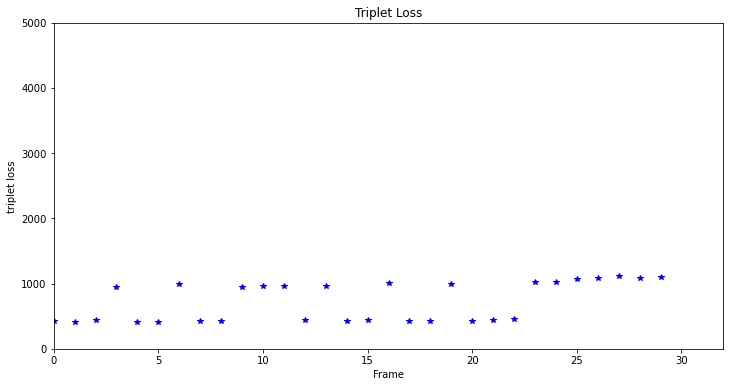

In [456]:
# Representing the variation of the triplet loss for Anchor and Positive from the intra class image and Negative from the inter class image

fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlim=(0, 32), ylim=(0, 5000))
ax.plot(res_triplet_loss_serie[0], '*',color='blue', ) 
plt.title("Triplet Loss")
plt.xlabel("Frame")
plt.ylabel("triplet loss")
plt.show()

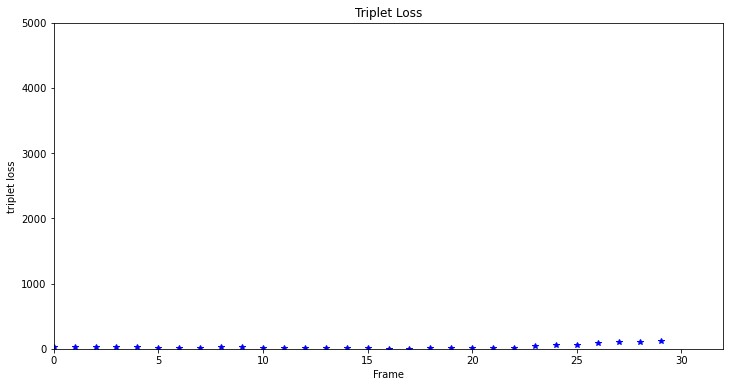

In [452]:
# Representing the variation of the triplet loss for Anchor from 31 frame (to be labelized) and Positive, Negative from the inter class images

fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlim=(0, 32), ylim=(0, 5000))
ax.plot(res_triplet_loss_serie[0], '*',color='blue') 
plt.title("Triplet Loss")
plt.xlabel("Frame")
plt.ylabel("triplet loss")
plt.show()